<a href="https://colab.research.google.com/github/meghanadevi63/HeartDisease_ECG/blob/main/wvd_cnn_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
# Install required libraries
!pip install opencv-python-headless

# Import libraries
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.applications import VGG16

# Enable inline plotting
%matplotlib inline

In [4]:
# Mount Google Drive
from google.colab import drive
drive.mount('/drive')

# Set path to your dataset (update the path to your folder)
data_dir = '/drive/MyDrive/dataset'  # Replace with your path

Mounted at /drive


In [5]:
# Parameters
IMG_SIZE = (128, 128)  # Use 128x128 for balance between memory and feature extraction
BATCH_SIZE = 16  # Small batch size for small dataset

# Load images from folders
def load_images(data_dir):
    images = []
    labels = []
    class_names = ['normal', 'abnormal']

    for label, class_name in enumerate(class_names):
        class_dir = os.path.join(data_dir, class_name)
        for img_name in os.listdir(class_dir):
            img_path = os.path.join(class_dir, img_name)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, IMG_SIZE)
                img = img / 255.0  # Normalize to [0, 1]
                images.append(img)
                labels.append(label)
            else:
                print(f"Failed to load image: {img_path}")

    return np.array(images), np.array(labels)

# Load dataset
data_dir = '/drive/MyDrive/dataset'  # Update based on upload method
X, y = load_images(data_dir)

# Split into train, validation, and test sets (replicating your split)
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

print(f"Training samples: {len(X_train)}")
print(f"Validation samples: {len(X_val)}")
print(f"Test samples: {len(X_test)}")

# Verify class distribution
print(f"Training normal samples: {sum(y_train == 0)}")
print(f"Training abnormal samples: {sum(y_train == 1)}")

# Use provided class weights
class_weight_dict = {0: 3.4285714285714284, 1: 0.5853658536585366}
print(f"Class weights: {class_weight_dict}")

Training samples: 48
Validation samples: 10
Test samples: 11
Training normal samples: 7
Training abnormal samples: 41
Class weights: {0: 3.4285714285714284, 1: 0.5853658536585366}


In [6]:
# Data augmentation for training
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.3,
    height_shift_range=0.3,
    horizontal_flip=True,
    vertical_flip=True,
    zoom_range=0.2,
    shear_range=0.2,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [7]:
# Load pre-trained VGG16
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False  # Freeze base model layers

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(64, activation='relu'),  # Reduced size for small dataset
    Dropout(0.5),
    Dense(1, activation='sigmoid')  # Binary classification
])

# Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Display model summary
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)              │ (None, 4, 4, 512)      │    14,714,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 512)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 64)             │        32,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,747,585 (56.26 MB)

 Trainable params: 32,897 (128.50 KB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [8]:
# Callbacks
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
checkpoint = ModelCheckpoint('/drive/MyDrive/best_model.h5',
                            monitor='val_accuracy', save_best_only=True)

# Train the model
history = model.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    epochs=50,  # Increased epochs for small dataset
    validation_data=(X_val, y_val),
    class_weight=class_weight_dict,
    callbacks=[early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step - accuracy: 0.2222 - loss: 0.8164

3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.2396 - loss: 0.8213 - val_accuracy: 0.9000 - val_loss: 0.5682
Epoch 2/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 9s 138ms/step - accuracy: 0.4167 - loss: 0.8001 - val_accuracy: 0.9000 - val_loss: 0.5256
Epoch 3/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 133ms/step - accuracy: 0.6484 - loss: 0.6124 - val_accuracy: 0.9000 - val_loss: 0.4985
Epoch 4/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 104ms/step - accuracy: 0.4792 - loss: 0.8241 - val_accuracy: 0.9000 - val_loss: 0.5233
Epoch 5/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 189ms/step - accuracy: 0.4792 - loss: 0.7282 - val_accuracy: 0.9000 - val_loss: 0.5359
Epoch 6/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 124ms/step - accuracy: 0.5000 - loss: 0.6414 - val_accuracy: 0.9000 - val_loss: 0.5353
Epoch 7/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.5573 - loss: 0.6236 - val_accuracy: 0.9000 - val_loss: 0.5267
Epoch 8/50
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 168ms/step - accuracy: 0.6380 - loss: 0.5803 - val_accuracy: 0.9000 - val_loss: 0.5141
Epoch

1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step - accuracy: 0.8182 - loss: 0.5523
Test Accuracy: 0.8182
Test Loss: 0.5523


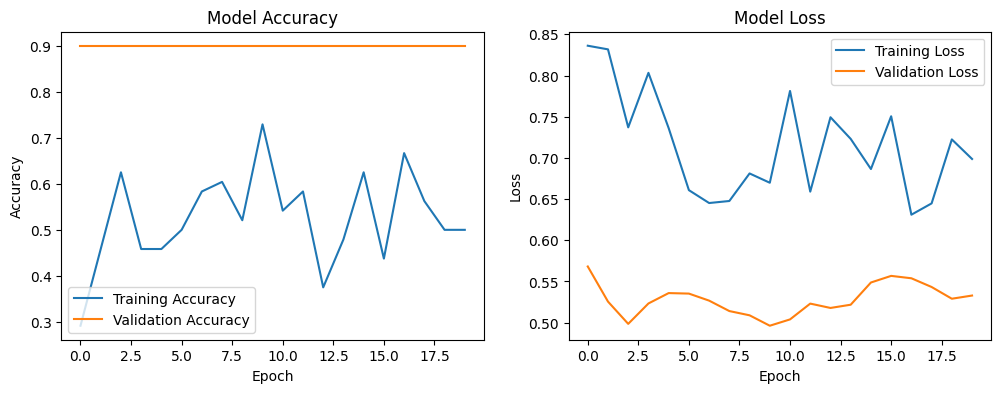

1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 549ms/step
              precision    recall  f1-score   support

      normal       0.00      0.00      0.00         2
    abnormal       0.82      1.00      0.90         9

    accuracy                           0.82        11
   macro avg       0.41      0.50      0.45        11
weighted avg       0.67      0.82      0.74        11



In [9]:
# Evaluate on test set
test_loss, test_accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test Loss: {test_loss:.4f}")

# Plot training history
plt.figure(figsize=(12, 4))

# Accuracy plot
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

# Loss plot
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.savefig('/drive/MyDrive/training_plot.png')  # Save plot
plt.show()

# Classification report
y_pred = (model.predict(X_test) > 0.5).astype(int)
print(classification_report(y_test, y_pred, target_names=['normal', 'abnormal'], zero_division=0))

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step


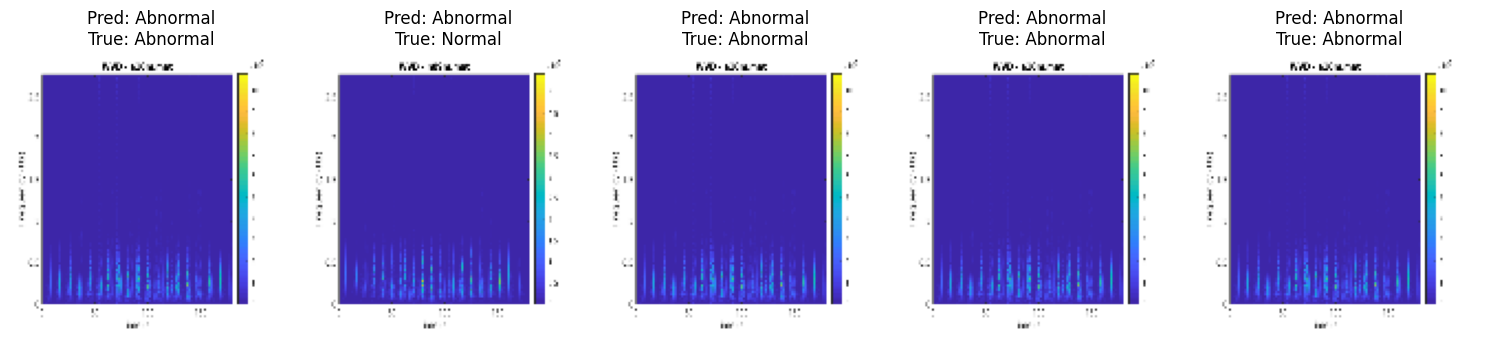

In [10]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os

# Function to predict on a single image
def predict_image(img_path, model):
    img = cv2.imread(img_path)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None, None
    img = cv2.resize(img, IMG_SIZE)
    img_display = img.copy()  # Keep original for display
    img = img / 255.0
    img = np.expand_dims(img, axis=0)  # Add batch dimension
    prediction = model.predict(img)
    label = 'Normal' if prediction[0] < 0.5 else 'Abnormal'
    return img_display, label

# Visualize predictions on test set
data_dir = '/drive/MyDrive/dataset'  # Update if your dataset path differs
plt.figure(figsize=(15, 5))
test_indices = np.random.choice(len(X_test), min(5, len(X_test)), replace=False)  # Handle small test set

for i, idx in enumerate(test_indices):
    class_name = 'normal' if y_test[idx] == 0 else 'abnormal'
    class_dir = os.path.join(data_dir, class_name)
    # Get a random image from the correct class folder
    class_images = [f for f in os.listdir(class_dir) if f.endswith(('.png', '.jpg', '.jpeg'))]
    if not class_images:
        print(f"No images found in {class_dir}")
        continue
    img_name = class_images[0]  # Use first image (or randomize if needed)
    img_path = os.path.join(class_dir, img_name)

    img, pred = predict_image(img_path, model)
    if img is not None:
        plt.subplot(1, 5, i+1)
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
        plt.title(f"Pred: {pred}\nTrue: {'Normal' if y_test[idx] == 0 else 'Abnormal'}")
        plt.axis('off')

plt.tight_layout()
plt.savefig('/drive/MyDrive/predictions.png')
plt.show()

In [11]:
# Save the model
model.save('/drive/MyDrive/ecg_wvd_classifier.keras')

# Download if needed
from google.colab import files
files.download('/drive/MyDrive/ecg_wvd_classifier.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>